### Import Libraries

In [1]:
from IPython.display import clear_output

In [2]:
!pip install git+https://github.com/tensorflow/examples.git
clear_output()

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt

AUTOTUNE = tf.data.AUTOTUNE

In [4]:
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "white",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "grey",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})

### Load Dataset

In [5]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteCNS94V/cycle_gan-trainA.tfrecord


  0%|          | 0/1067 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteCNS94V/cycle_gan-trainB.tfrecord


  0%|          | 0/1334 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteCNS94V/cycle_gan-testA.tfrecord


  0%|          | 0/120 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteCNS94V/cycle_gan-testB.tfrecord


  0%|          | 0/140 [00:00<?, ? examples/s]

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0. Subsequent calls will reuse this data.


In [6]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

### Data Processing

In [7]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [8]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [9]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [10]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [11]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [12]:
train_horses = train_horses.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_zebras = train_zebras.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [13]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

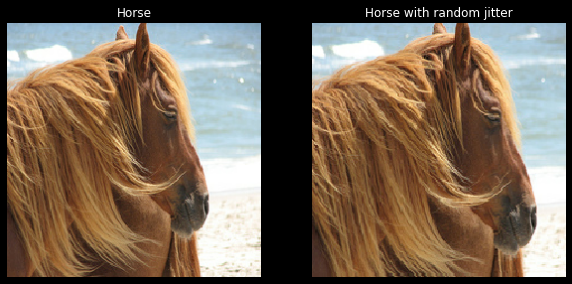

In [15]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('Horse')
plt.axis('off')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.axis('off')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

### Import and reuse Pix2Pix models using modified U-Net

In [16]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

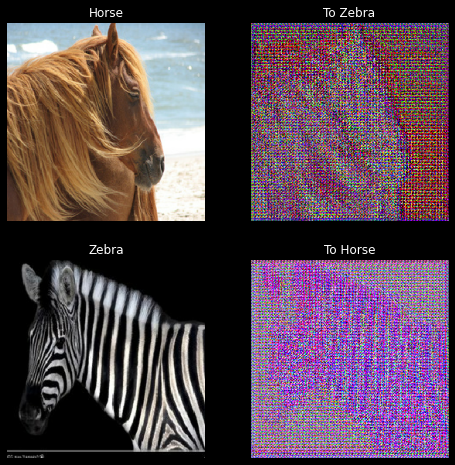

In [19]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.axis('off')
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.axis('off')
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

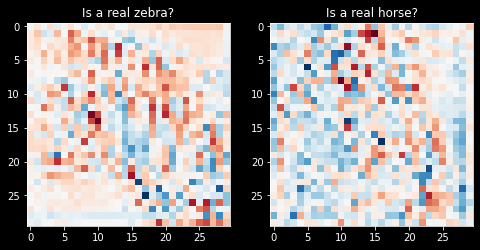

In [20]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

### Loss functions

In [21]:
LAMBDA = 10

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [23]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [24]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [25]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [26]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

### Checkpoints

In [27]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

### Model Training

In [28]:
EPOCHS = 40

In [29]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [30]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

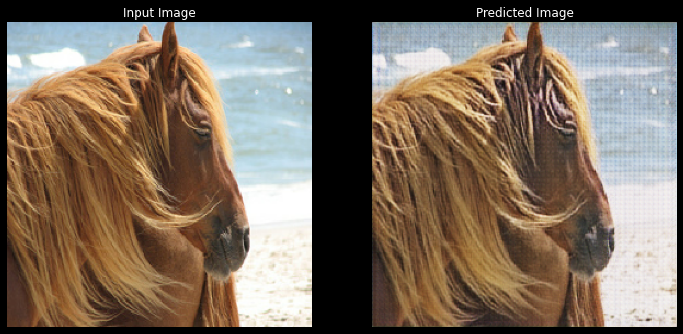

Time taken for epoch 2 is 471.19589948654175 sec

..

KeyboardInterrupt: ignored

In [31]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_horse)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

---